In [1]:
"""
Train convex LassoNet models on a synthetic classification dataset using convex optimization.
"""

import sys
sys.path.append("..")

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from cvx_nn import optimize_path
from cvx_nn.datasets import generate_synthetic_classification

In [3]:
# Generate realizable synthetic classification problem (ie. Figure 1)
n_train = 250
n_test = 250
d = 50
hidden_units = 100
kappa = 10  # condition number

(X_train, y_train), (X_test, y_test) = generate_synthetic_classification(123, n_train, n_test, d, hidden_units, kappa)

In [ ]:
lambda_path = np.flip(np.logspace(-2, 0, 10))

results = optimize_path(
               lambda_path,
               X_train, 
               y_train, 
               X_test, 
               y_test, 
               train_metrics=["accuracy"],
               test_metrics=["accuracy"],
               additional_metrics=["feature_sparsity", "active_features", "step_size"],
               max_patterns=250,
               formulation="grelu_lasso_net",
               backend="numpy",
#                model_dest="./models", # comment remove comment to save models to disk.
               verbose=True)

In [5]:
# extract summary statistics:
accuracies = [metrics["train_accuracy"][-1] for (model, metrics) in results.values()]
sparsities = [metrics["feature_sparsity"][-1] for (model, metrics) in results.values()]

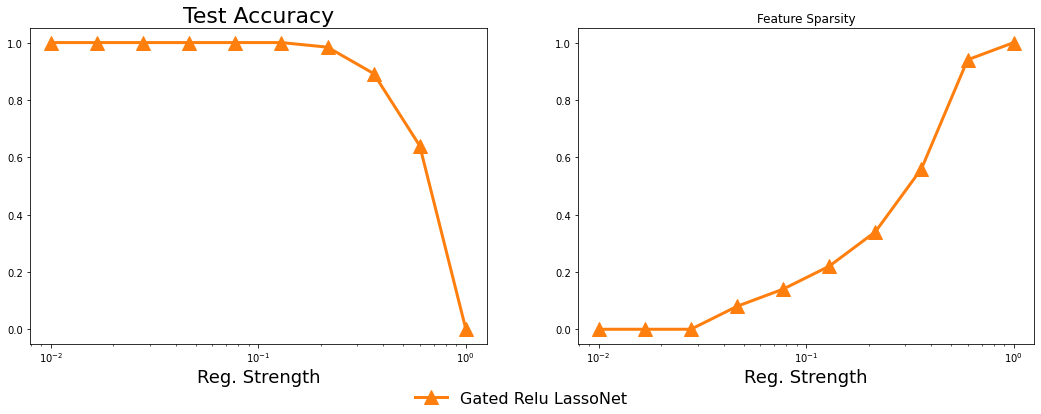

In [6]:
# Plot Results

fig = plt.figure(figsize=(18,6))
spec = fig.add_gridspec(ncols=2, nrows=1)
ax0 = fig.add_subplot(spec[0, 0])

ax0.plot(np.flip(lambda_path), 
         np.flip(accuracies), 
         label="Gated Relu LassoNet", 
         color="#ff7f0e",
         marker="^",
         markevery=1,
         markersize=14,
         linewidth="3")

ax0.set_title("Test Accuracy", fontsize=22)
ax0.set_xlabel("Reg. Strength", fontsize=18)
ax0.set_xscale("log")

ax1 = fig.add_subplot(spec[0, 1])

ax1.plot(np.flip(lambda_path), 
         np.flip(sparsities), 
         label="Gated Relu LassoNet", 
         color="#ff7f0e",
         marker="^",
         markevery=1,
         markersize=14,
         linewidth="3")

ax1.set_title("Feature Sparsity")
ax1.set_xlabel("Reg. Strength", fontsize=18)
ax1.set_xscale("log")
handles, labels = ax0.get_legend_handles_labels()
legend = fig.legend(
    handles=handles,
    labels=labels,
    loc="lower center",
    borderaxespad=0.1,
    fancybox=False,
    shadow=False,
    ncol=2,
    fontsize=16,
    frameon=False,
)
fig.subplots_adjust(
    bottom=0.15,
)